* changed by nov05 on 2024-04-16  
* [make sure `$ pip install "notebook<7"`](https://gist.github.com/Nov05/1d49183a91456a63e13782e5f49436be?permalink_comment_id=5024206#gistcomment-5024206)

# Initialize a game

In [1]:
from ConnectN import ConnectN
game_setting = {'size':(6,6), 'N':4, 'pie_rule':True}
game = ConnectN(**game_setting)

<IPython.core.display.Javascript object>


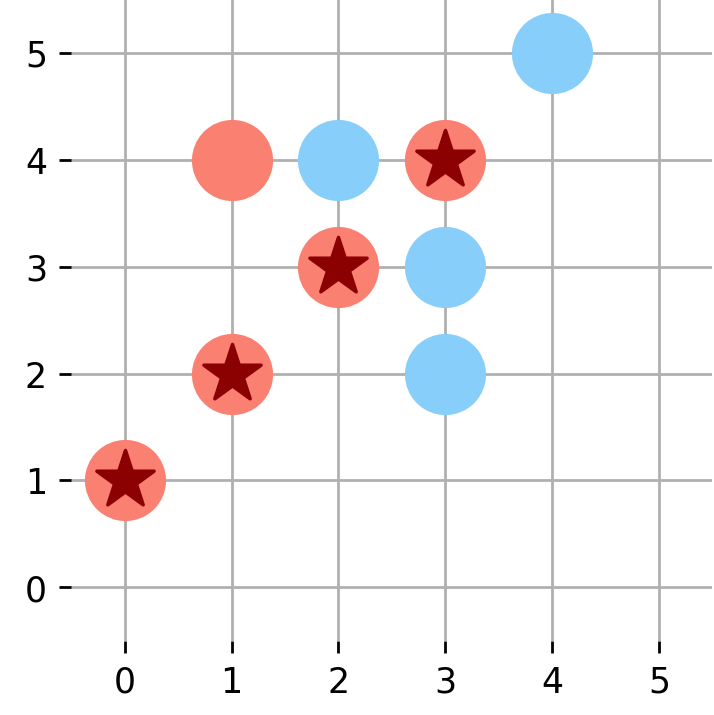

In [2]:
%matplotlib notebook
from Play import Play
gameplay = Play(ConnectN(**game_setting), 
                player1=None,  ## red
                player2=None)  ## blue
## remember to click on the "power" button when finish
## or other games can't be played

# Define our policy

Please go ahead and define your own policy! See if you can train it under 1000 games and with only 1000 steps of exploration in each move.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import *
import numpy as np

from ConnectN import ConnectN
game_setting = {'size':(6,6), 'N':4}
game = ConnectN(**game_setting)


class Policy(nn.Module):

    def __init__(self, game):
        super(Policy, self).__init__()

        # input = 6x6 board
        # convert to 5x5x8
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2, stride=1, bias=False)
        # 5x5x16 to 3x3x32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, bias=False)

        self.size=3*3*32
        
        # the part for actions
        self.fc_action1 = nn.Linear(self.size, self.size//4)
        self.fc_action2 = nn.Linear(self.size//4, 36)
        
        # the part for the value function
        self.fc_value1 = nn.Linear(self.size, self.size//6)
        self.fc_value2 = nn.Linear(self.size//6, 1)
        self.tanh_value = nn.Tanh()
        
    def forward(self, x):

        y = F.leaky_relu(self.conv1(x))
        y = F.leaky_relu(self.conv2(y))
#         y = y.view(-1, self.size)
        y = y.reshape(-1, self.size)
        
        # action head
        a = self.fc_action2(F.leaky_relu(self.fc_action1(y)))
        
        avail = (torch.abs(x.squeeze())!=1).type(torch.FloatTensor)
#         avail = avail.view(-1, 36)
        avail = avail.reshape(-1, 36)
        maxa = torch.max(a)
        exp = avail*torch.exp(a-maxa)
        prob = exp/torch.sum(exp)
        
        # value head
        value = self.tanh_value(self.fc_value2(F.leaky_relu( self.fc_value1(y) )))
        return prob.view(6,6), value

policy = Policy(game)
print(policy)

Policy(
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1), bias=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (fc_action1): Linear(in_features=288, out_features=72, bias=True)
  (fc_action2): Linear(in_features=72, out_features=36, bias=True)
  (fc_value1): Linear(in_features=288, out_features=48, bias=True)
  (fc_value2): Linear(in_features=48, out_features=1, bias=True)
  (tanh_value): Tanh()
)


# Define a MCTS player for Play

In [4]:
import MCTS
from copy import copy
import random

def Policy_Player_MCTS(game):
    mytree = MCTS.Node(copy(game))
    for _ in range(1000):
        mytree.explore(policy) 
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
    return mytreenext.game.last_move

def Random_Player(game):
    return random.choice(game.available_moves())    

# Play a game against a random policy

<IPython.core.display.Javascript object>


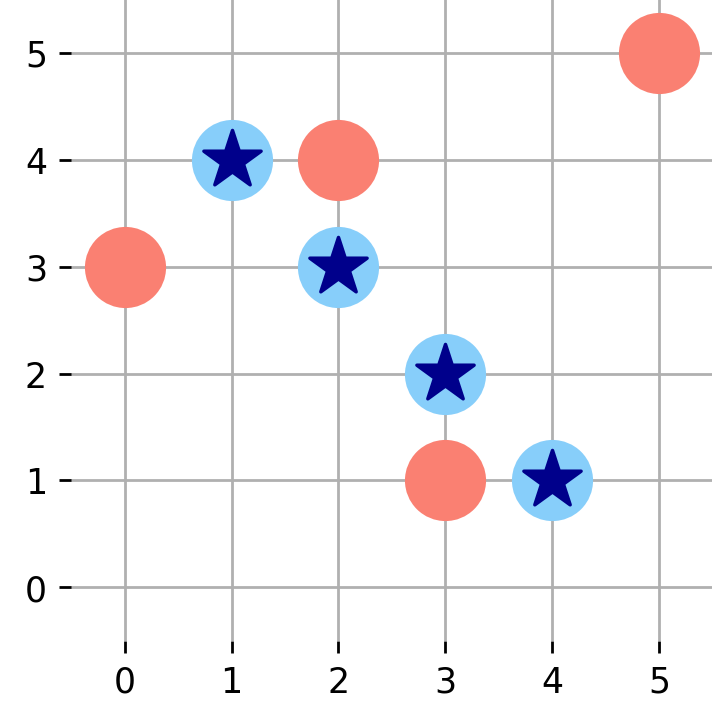

D:\github\udacity-deep-reinforcement-learning\alphazero\MCTS.py:72: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  return game.available_moves(), tinv(prob)[mask].view(-1), v.squeeze().squeeze()


In [5]:
%matplotlib notebook
from Play import Play
gameplay = Play(ConnectN(**game_setting), 
                player1=Policy_Player_MCTS,  ## red
                player2=None)  ## blue
#                 player2=Random_Player)  ## blue
## remember to click on the "power" button when finish
## or other games can't be played

# Training

Beware, training is **VERY VERY** slow!!  
⚠️ Don't panic. It takes about 2 to 3 hours to train 600 episodes. You can change the code to enable training on GPU.   

In [6]:
# initialize our alphazero agent and optimizer
import torch.optim as optim
game = ConnectN(**game_setting)
policy = Policy(game)
optimizer = optim.Adam(policy.parameters(), lr=.01, weight_decay=1.e-5)
!pip install progressbar

In [7]:
# train our agent
from collections import deque
import MCTS

# try a higher number
episodes = 600 #2000

import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()

outcomes = []
policy_loss = []
Nmax = 1000

for e in range(episodes):

    mytree = MCTS.Node(game)
    logterm = []
    vterm = []
    
    while mytree.outcome is None:
        for _ in range(Nmax):
            mytree.explore(policy)
            if mytree.N >= Nmax:
                break
            
        current_player = mytree.game.player
        mytree, (v, nn_v, p, nn_p) = mytree.next()
        mytree.detach_mother()
        
        loglist = torch.log(nn_p)*p
        constant = torch.where(p>0, p*torch.log(p),torch.tensor(0.))
        logterm.append(-torch.sum(loglist-constant))

        vterm.append(nn_v*current_player)
        
    # we compute the "policy_loss" for computing gradient
    outcome = mytree.outcome
    outcomes.append(outcome)
    
    loss = torch.sum( (torch.stack(vterm)-outcome)**2 + torch.stack(logterm) )
    optimizer.zero_grad()
    loss.backward()
    policy_loss.append(float(loss))
    optimizer.step()
    
    if e%10==0:
        print("game: ",e+1, ", mean loss: {:3.2f}".format(np.mean(policy_loss[-20:])),
              ", recent outcomes: ", outcomes[-10:])
    if e>=500 and e%50==0:
        torch.save(policy,'6-6-4-pie-{:d}.mypolicy'.format(e))
    del loss
    
    timer.update(e+1)
timer.finish()

D:\github\udacity-deep-reinforcement-learning\alphazero\MCTS.py:72: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  return game.available_moves(), tinv(prob)[mask].view(-1), v.squeeze().squeeze()
D:\Users\guido\miniconda3\envs\drlnd_py310\lib\site-packages\torch\autograd\__init__.py:266: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


game:  1 , mean loss: 31.58 , recent outcomes:  [-1]


game:  11 , mean loss: 24.73 , recent outcomes:  [1, 1, 1, -1, 1, 1, 1, 1, 1, -1]


game:  21 , mean loss: 30.02 , recent outcomes:  [1, -1, 1, 1, -1, -1, 1, 0, -1, -1]


game:  31 , mean loss: 27.25 , recent outcomes:  [1, 1, 1, 1, -1, 1, -1, 1, 1, 1]


game:  41 , mean loss: 17.47 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, -1]


game:  51 , mean loss: 16.76 , recent outcomes:  [1, 1, 1, -1, -1, 1, 1, 1, -1, 1]


game:  61 , mean loss: 13.29 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  71 , mean loss: 9.12 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  81 , mean loss: 7.96 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  91 , mean loss: 6.72 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, -1, 1]


game:  101 , mean loss: 8.26 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, -1, 1, 1]


game:  111 , mean loss: 12.46 , recent outcomes:  [-1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  121 , mean loss: 12.95 , recent outcomes:  [1, 1, 1, 1, -1, 1, 1, 1, 1, 1]


game:  131 , mean loss: 7.62 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  141 , mean loss: 3.82 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  151 , mean loss: 3.79 , recent outcomes:  [1, 1, 1, -1, 1, 1, 1, 1, 1, 1]


game:  161 , mean loss: 3.83 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  171 , mean loss: 4.06 , recent outcomes:  [-1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  181 , mean loss: 3.73 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  191 , mean loss: 3.04 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  201 , mean loss: 2.52 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  211 , mean loss: 2.13 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  221 , mean loss: 1.94 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  231 , mean loss: 2.02 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  241 , mean loss: 4.22 , recent outcomes:  [1, 1, 1, -1, 1, 1, 1, 1, 1, 1]


game:  251 , mean loss: 4.53 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  261 , mean loss: 2.98 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  271 , mean loss: 2.23 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  281 , mean loss: 1.53 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  291 , mean loss: 1.66 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  301 , mean loss: 3.29 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, -1]


game:  311 , mean loss: 3.01 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  321 , mean loss: 1.52 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  331 , mean loss: 1.81 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  341 , mean loss: 2.05 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  351 , mean loss: 1.81 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  361 , mean loss: 3.32 , recent outcomes:  [1, -1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  371 , mean loss: 3.09 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  381 , mean loss: 1.02 , recent outcomes:  [1, 1, -1, 1, 1, 1, 1, 1, 1, 1]


game:  391 , mean loss: 1.16 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  401 , mean loss: 2.82 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, -1, 1, 1]


game:  411 , mean loss: 3.08 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  421 , mean loss: 1.48 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  431 , mean loss: 1.36 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  441 , mean loss: 1.06 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  451 , mean loss: 1.66 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  461 , mean loss: 4.73 , recent outcomes:  [1, -1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  471 , mean loss: 8.16 , recent outcomes:  [1, 1, -1, 1, 1, 1, -1, 1, 1, 1]


game:  481 , mean loss: 5.44 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  491 , mean loss: 2.69 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  501 , mean loss: 3.73 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  511 , mean loss: 3.51 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  521 , mean loss: 7.43 , recent outcomes:  [1, 1, 1, 1, 1, -1, 1, 1, 1, 1]


game:  531 , mean loss: 11.50 , recent outcomes:  [1, 1, 1, -1, 1, 1, 1, 1, 1, 1]


game:  541 , mean loss: 7.35 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  551 , mean loss: 4.81 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  561 , mean loss: 4.28 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  571 , mean loss: 3.69 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  581 , mean loss: 5.98 , recent outcomes:  [1, -1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  591 , mean loss: 6.86 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop: 100% |###########################################| Time: 1:25:59


<IPython.core.display.Javascript object>


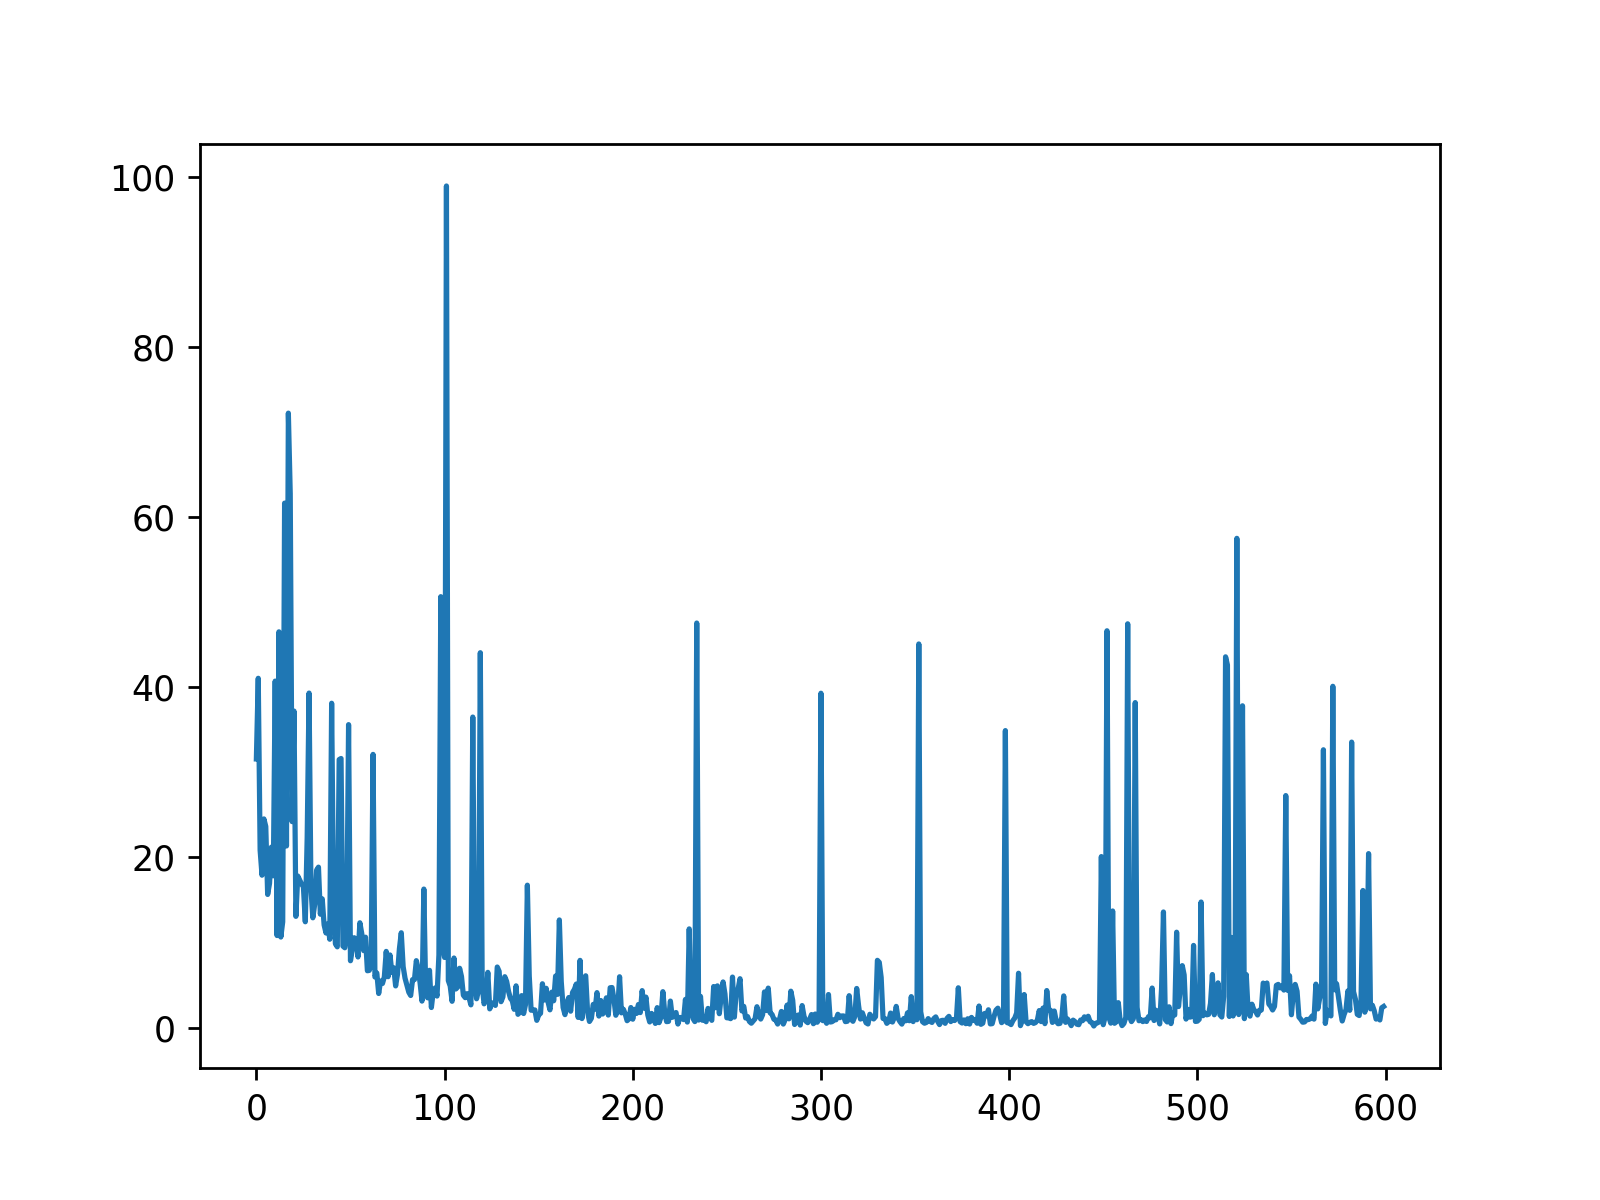

In [8]:
# plot your losses
import matplotlib.pyplot as plt
plt.plot(policy_loss)
plt.show()

# setup environment to pit your AI against the challenge policy '6-6-4-pie.policy'

In [23]:
policy_file = '6-6-4-pie.policy'  ## solution
# policy_file = '6-6-4-pie-500.mypolicy'
challenge_policy = torch.load(policy_file)

def Challenge_Player_MCTS(game):
    mytree = MCTS.Node(copy(game))
    for _ in range(1000):
        mytree.explore(challenge_policy)
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
    return mytreenext.game.last_move

# Let the game begin!

<IPython.core.display.Javascript object>


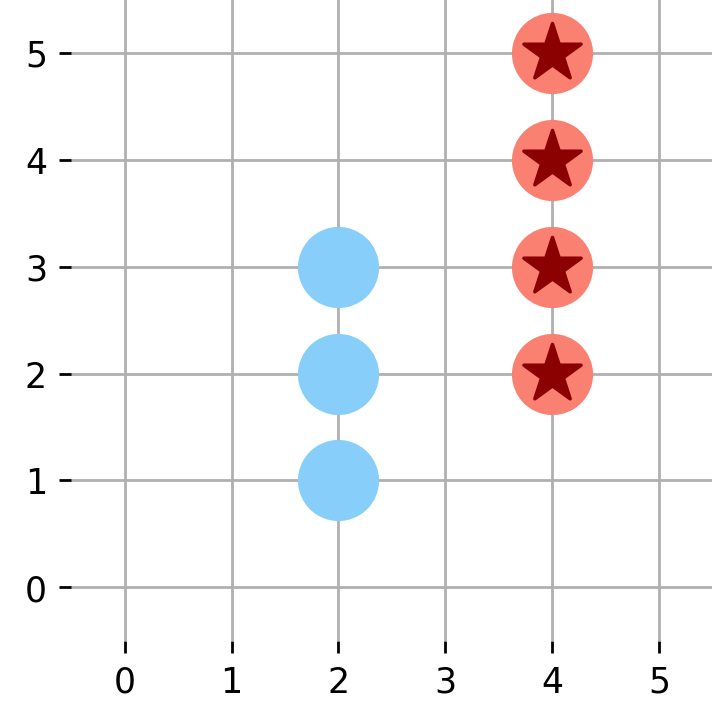

D:\github\udacity-deep-reinforcement-learning\alphazero\Play.py:60: UserWarning: frames=<bound method Play.move_generator of <Play.Play object at 0x0000017C988B0DC0>> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  self.anim = FuncAnimation(self.fig, self.draw_move, frames=self.move_generator, interval=500, repeat=False)


In [24]:
%matplotlib notebook
gameplay=Play(ConnectN(**game_setting), 
              player1=Challenge_Player_MCTS,  ## red, trained 
              player2=Policy_Player_MCTS)  ## blue
## remember to click on the "power" button when finish
## or other games can't be played

<IPython.core.display.Javascript object>


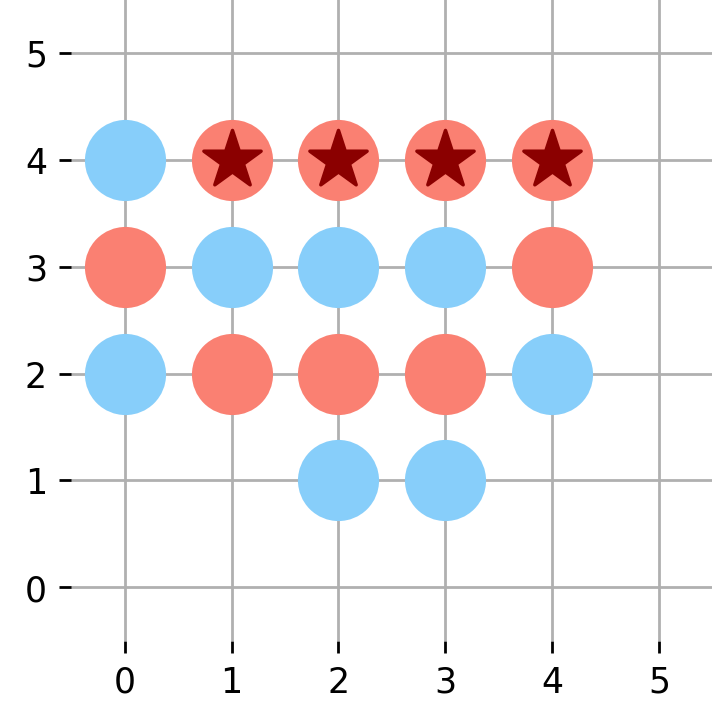

D:\github\udacity-deep-reinforcement-learning\alphazero\Play.py:60: UserWarning: frames=<bound method Play.move_generator of <Play.Play object at 0x0000017C9E277160>> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  self.anim = FuncAnimation(self.fig, self.draw_move, frames=self.move_generator, interval=500, repeat=False)


In [25]:
%matplotlib notebook
gameplay=Play(ConnectN(**game_setting), 
              player1=Policy_Player_MCTS,  ## red
              player2=Challenge_Player_MCTS)  ## blue, trained
## remember to click on the "power" button when finish
## or other games can't be played